In [1]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import accuracy_score

import scyan

# Data Import

In [2]:
marker_pop_matrix = pd.read_csv("/Users/quentinblampey/dev/scyan/exploration/marker_pop_matrix_aml.csv", index_col=0)
marker_pop_matrix

,CD19,CD4,CD8,CD34,CD20,CD45,CD123,CD11c,CD7,CD16,CD38,CD3,HLA-DR,CD64
Basophils,-1,-1,-1,-1,-1.0,-1.0,1,-1,-1.0,-1,NaN,-1,-1,-1
CD4 T cells,-1,1,-1,-1,-1.0,1.0,-1,-1,NaN,-1,-1.0,1,-1,-1
CD8 T cells,-1,-1,1,-1,-1.0,1.0,-1,-1,NaN,-1,-1.0,1,-1,-1
CD16- NK cells,-1,-1,-1,-1,-1.0,1.0,-1,-1,1.0,-1,NaN,-1,-1,-1
CD16+ NK cells,-1,-1,-1,-1,-1.0,1.0,-1,-1,1.0,1,NaN,-1,-1,-1
CD34+CD38+CD123- HSPCs,-1,-1,-1,1,-1.0,-1.0,-1,-1,-1.0,-1,1.0,-1,1,-1
CD34+CD38+CD123+ HSPCs,-1,-1,-1,1,-1.0,-1.0,1,-1,-1.0,-1,1.0,-1,1,-1
CD34+CD38lo HSCs,-1,-1,-1,1,-1.0,-1.0,-1,-1,-1.0,-1,-1.0,-1,1,-1
Mature B cells,1,-1,-1,-1,NaN,1.0,-1,-1,-1.0,-1,-1.0,-1,1,-1
Plasma B cells,1,-1,-1,-1,NaN,NaN,-1,-1,-1.0,-1,1.0,-1,-1,-1


In [3]:
marker_pop_matrix.drop("CD20", axis=1, inplace=True)

In [4]:
adata = sc.read_h5ad("/Users/quentinblampey/dev/external/acdc/adata.h5ad")
# adata = sc.read_h5ad("/Users/quentinblampey/data/pop_durva/misc/p1_to_6.h5ad")

# Computing probas

In [5]:
from scyan import Scyan

In [6]:
model = Scyan(adata, marker_pop_matrix, lr=1e-3, hidden_size=16, n_hidden_layers=5, n_layers=5, alpha_dirichlet=1.05, prior_std_nan=1)

INFO:scyan.model:The provided adata is copied, prefer to use model.adata from now on.
INFO:scyan.metric:AnnotationMetrics callback setup with n_samples=100
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
INFO:scyan.model:Initialized Scyan model with N=104184 cells, P=14 populations and M=13 markers. No covariate provided.


In [7]:
esc = EarlyStopping(monitor="loss_epoch", min_delta=0.5, patience=4, check_on_train_epoch_end=True)

In [8]:
trainer = pl.Trainer(max_epochs=40, callbacks=[esc])#, reload_dataloaders_every_epoch=True)#, callbacks=[AnnotationMetrics(n_samples=1000)])
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 18.4 K
---------------------------------------
18.2 K    Trainable params
182       Non-trainable params
18.4 K    Total params
0.074     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/bio/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 29: 100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=-51.8, v_num=106, mean_wasserstein_distance=0.282, silhouette_score=0.416, accuracy_score=0.958]  


In [9]:
model.predict().value_counts(normalize=True) * 100

CD4 T cells               24.871381
Monocytes                 19.874453
CD8 T cells               19.622015
Mature B cells            14.921677
Pre B cells                6.494279
CD16- NK cells             3.374798
CD34+CD38+CD123- HSPCs     2.794095
CD16+ NK cells             2.634762
pDCs                       1.371612
CD34+CD38lo HSCs           1.258351
Basophils                  1.146049
CD34+CD38+CD123+ HSPCs     0.734278
Plasma B cells             0.573984
Pro B cells                0.328265
dtype: float64

# Results

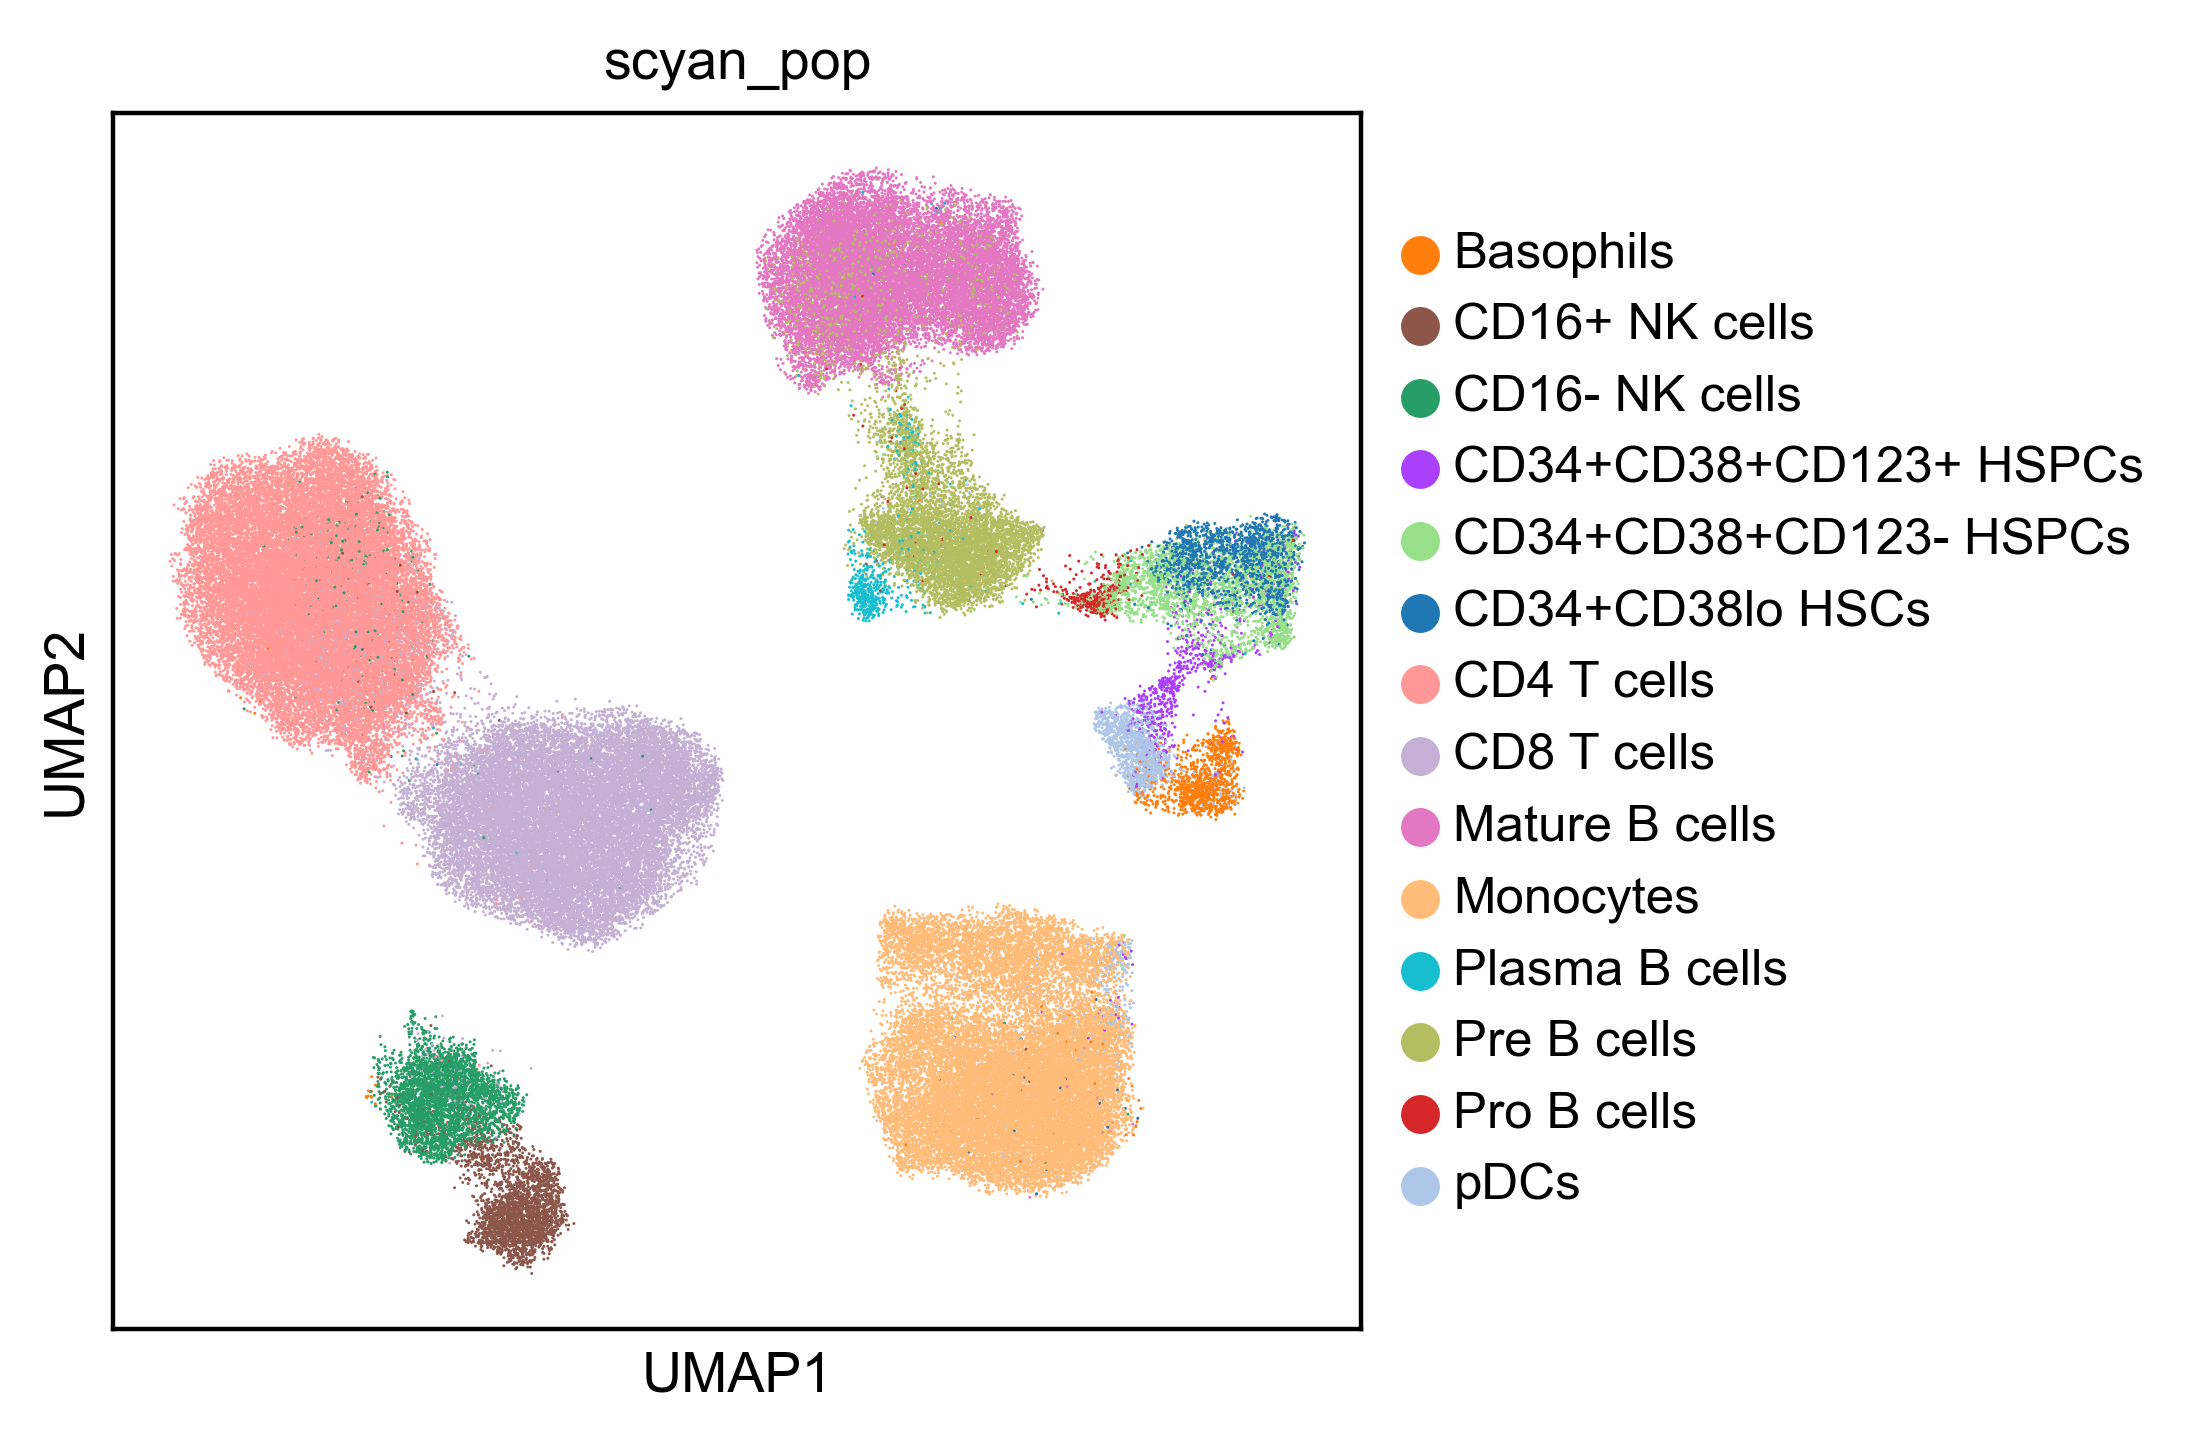

In [10]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (200)}):
    sc.pl.umap(model.adata, color="scyan_pop", palette={
        "CD4 T cells": "C12",
        "Basophils": "C1",
        "CD8 T cells": "C13",
        "CD16- NK cells": "C2",
        "CD16+ NK cells": "C5",
        "Monocytes": "C10",
        "Mature B cells": "C6",
        "Pre B cells": "C7",
        "Plasma B cells": "C8",
        "pDCs": "C9",
        "CD34+CD38+CD123+ HSPCs": "C4",
        "CD34+CD38+CD123- HSPCs": "C11",
        "CD34+CD38lo HSCs": "C0",
        "Pro B cells": "C3"
    })
    # ,palette={
    #         "Unknown": "gray",
    #         "B-Cell": "C11",
    #         "PMN/Mono/Macro": "C1",
    #         "Dendritic-Cell": "C10",
    #         "Epcam+": "C7",
    #         "Tcd4_naive/SCM": "C3",
    #         "Tcd4_CM": "C4",
    #         "Tcd4_EF/EM/activ": "C5",
    #         "Tcd4_reg": "C6",
    #         "Tcd8_naive/SCM": "C9",
    #         "Tcd8_CM": "C8",
    #         "Tcd8_EF/EM/activ": "C0",
    #         "Tcd8_RM": "C2"
    #     })

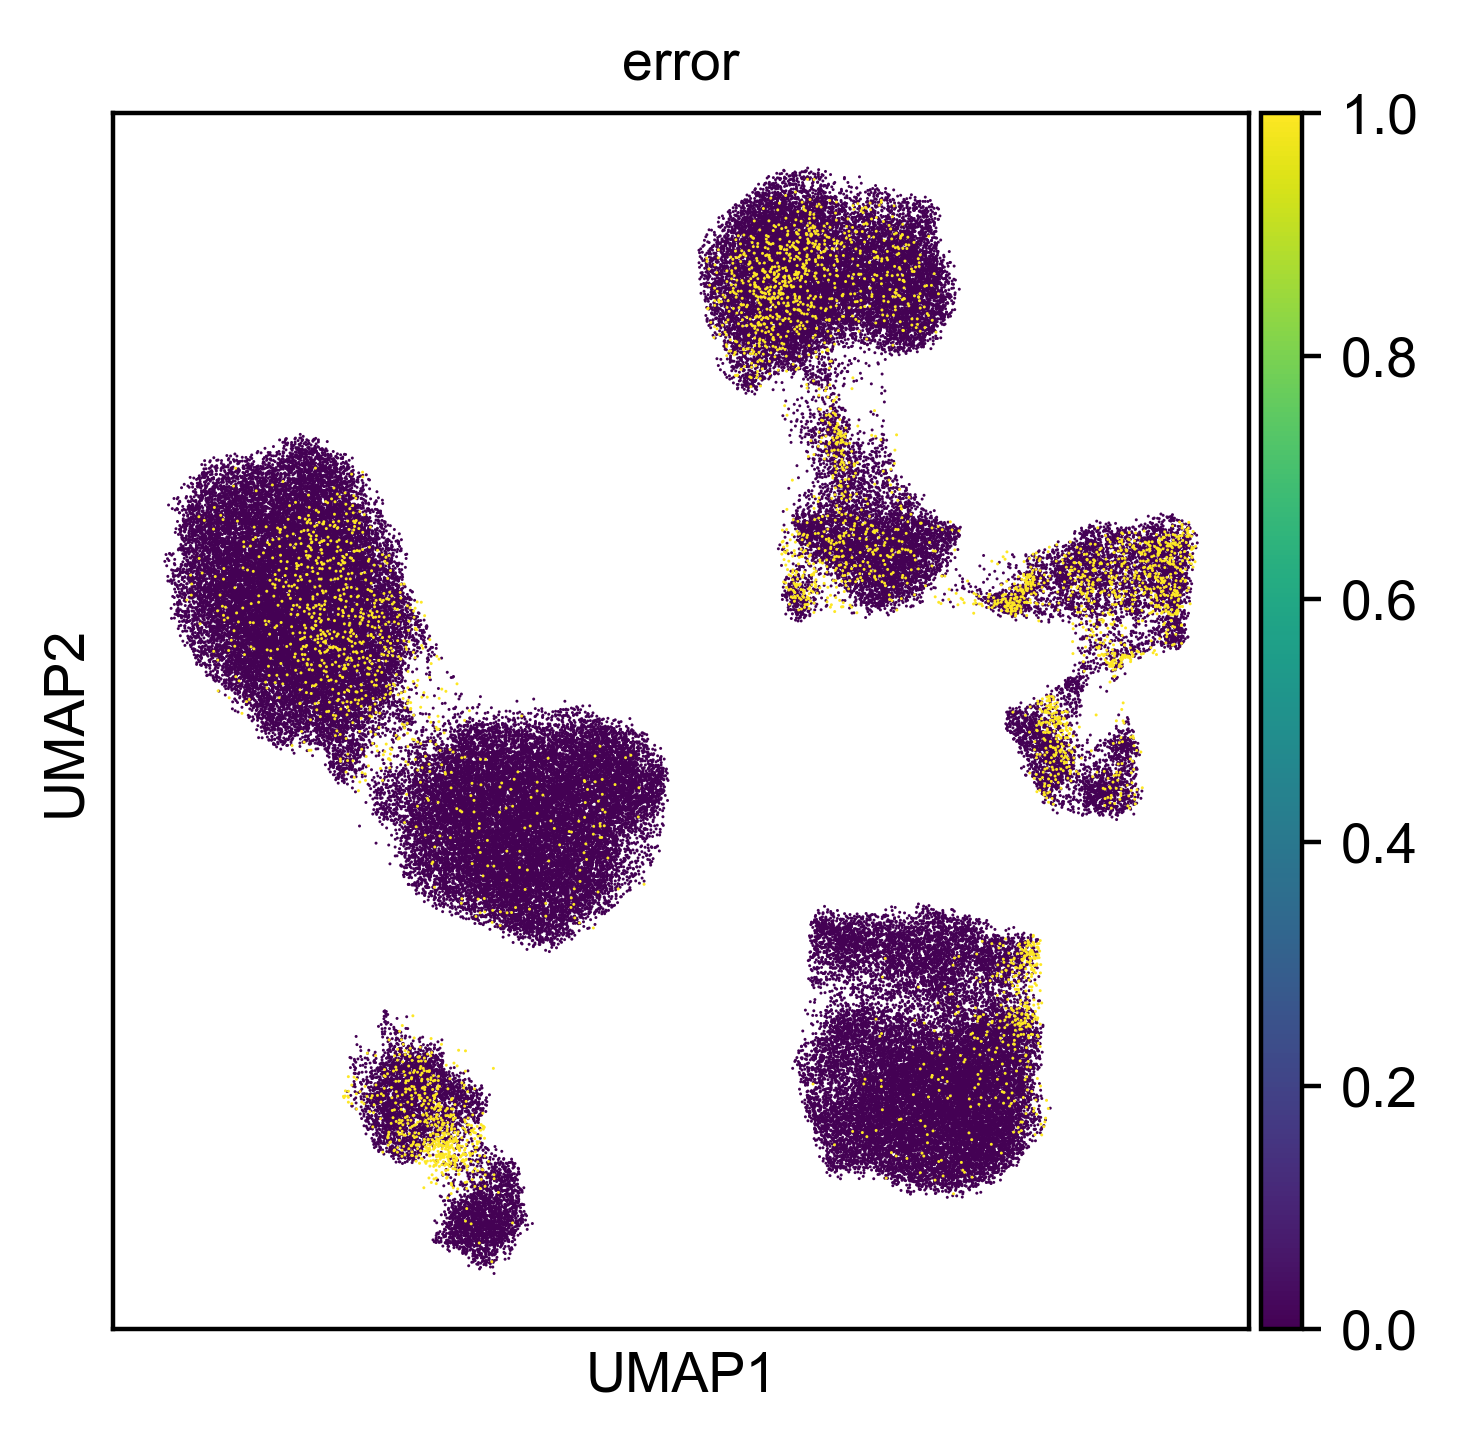

In [11]:
model.adata.obs["error"] = (model.adata.obs.cell_type != model.adata.obs.scyan_pop).astype(int)
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (200)}):
    sc.pl.umap(model.adata, color="error")

In [12]:
model.knn_predict()
accuracy_score(model.adata.obs.cell_type, model.adata.obs.scyan_knn_pop)

0.9782500191968057

# Results analysis and plotting tools

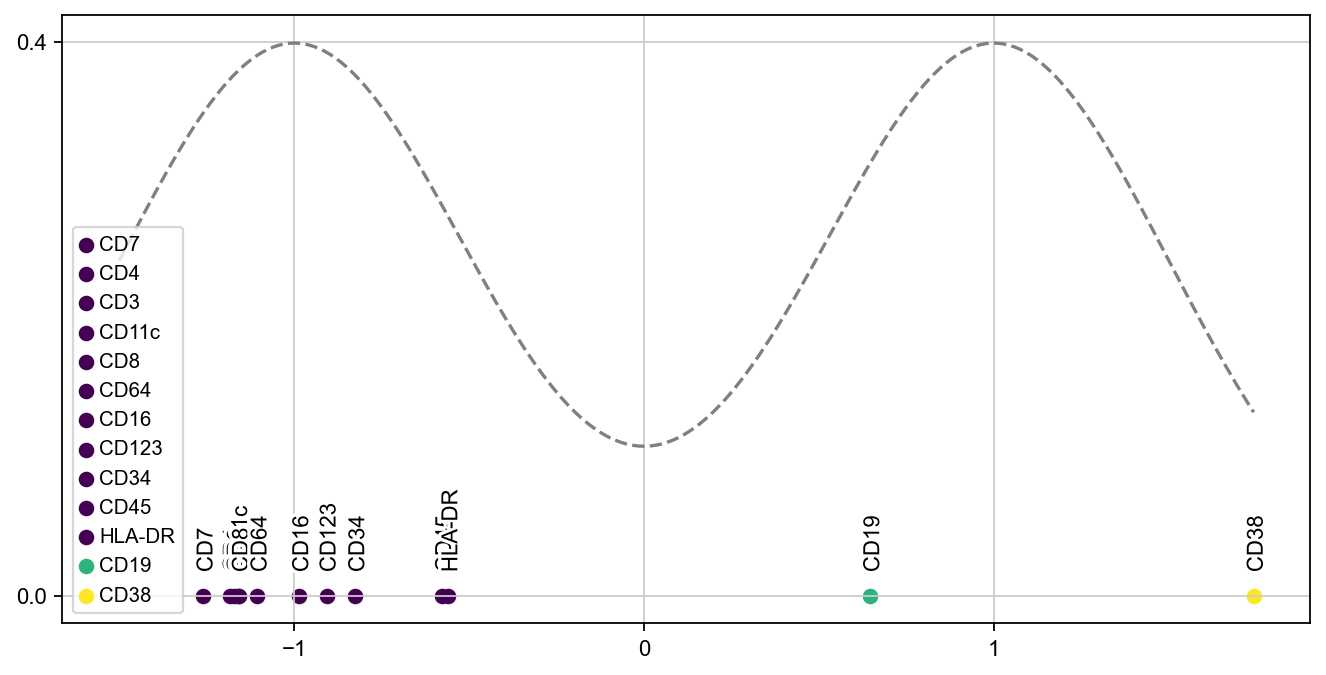

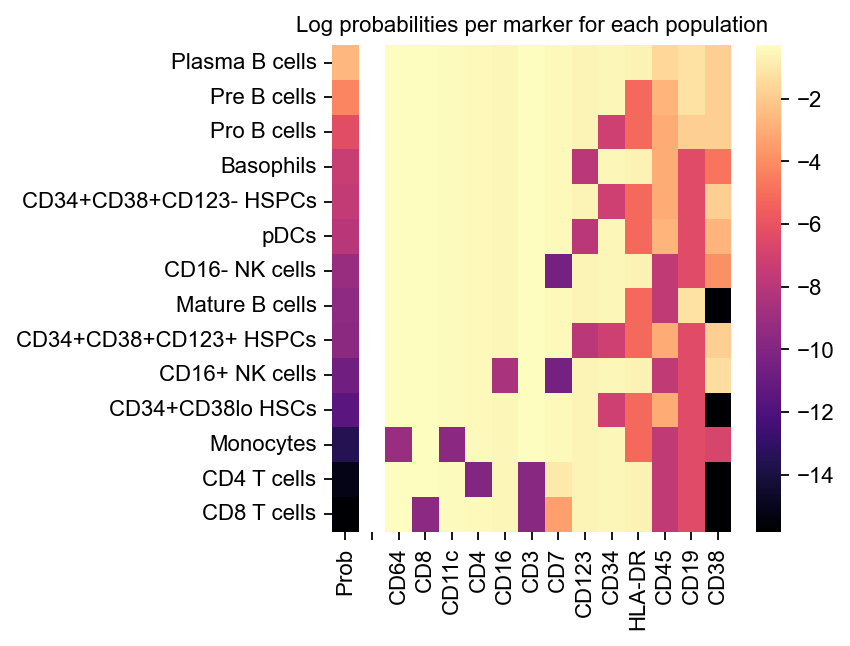

In [14]:
where = (model.adata.obs.cell_type == "Pre B cells") & (model.adata.obs.scyan_pop == "Plasma B cells")
# where = (model.adata.obs.cell_type == "CD4 T cells") & (model.adata.obs.scyan_pop == "CD16- NK cells")
# where = model.adata.obs.cell_type == "CD8 T cells"

scyan.plot.latent_expressions(model, where)
scyan.plot.probs_per_marker(model, where)

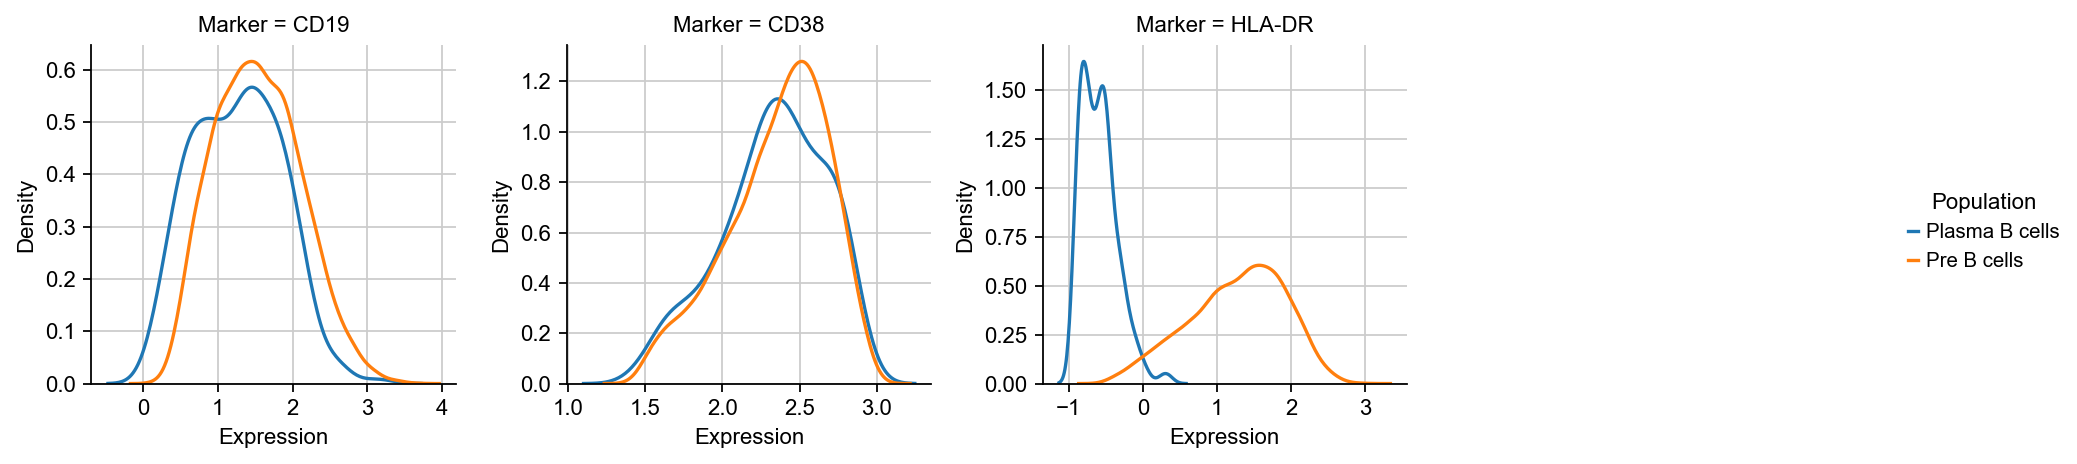

In [15]:
cell_type = "Pre B cells"
pred_types = ["Pre B cells", "Plasma B cells"]

markers = ["CD19", "CD38", "HLA-DR"]

adata_kde = model.adata[(model.adata.obs.cell_type == cell_type) & np.isin(model.adata.obs.scyan_pop, pred_types)]
scyan.plot.kde_per_population(adata_kde, "scyan_pop", markers=markers)